# Rabi experiment

In this tutorial we will combine the techniques explained in the other tutorials and show how to perform a Rabi experiment. For this tutorial we will need one Pulsar QCM to generate the Rabi pulses and one Pulsar QRM to perform the readout, although the QCM could be replaced by another QRM if needed.

Ports $\text{O}^{[1-2]}$ of the QCM are used for the driving pulse, while $\text{O}^{[1-2]}$ of the QRM are used for the readout pulse. Finally, ports $\text{I}^{[1-2]}$ are used for the acquisition of the readout tone. In this tutorial it is assumed $\text{O}^{1}$ of the QRM is connected to $\text{I}^{1}$ of the QRM for time of flight calibration.
Furthermore we assume that $\text{O}^{1}$ of the QCM and $\text{O}^{2}$ of the QRM are connected to an external oscilloscope to view the Rabi experiment patter. The scope can be triggered of marker 1 of the QCM.

In [1]:
#Set up the environment.
import pprint
import os
import scipy.signal
import math
import json
import matplotlib.pyplot as plt
import numpy as np

from pulsar_qcm.pulsar_qcm import pulsar_qcm
from pulsar_qrm.pulsar_qrm import pulsar_qrm

#Close any existing connections to any pulsar module
pulsar_qcm.close_all()
pulsar_qrm.close_all()

#Connect to the Pulsar QRM at alternate address.
pulsar_qrm = pulsar_qrm("qrm", "192.168.0.2")

#Connect to the Pulsar QCM at default IP address.
pulsar_qcm = pulsar_qcm("qcm", "192.168.0.3")

#Reset the Pulsar QCM for good measure.
pulsar_qcm.reset()
print("QCM status:")
print(pulsar_qcm.get_system_status())
print()

#Reset the Pulsar QRM for good measure.
pulsar_qrm.reset()
print("QRM status:")
print(pulsar_qrm.get_system_status())

QCM status:
{'status': 'OKAY', 'flags': []}

QRM status:
{'status': 'OKAY', 'flags': []}


As demonstrated in the synchronization tutorial, the SYNQ technology synchronizes the programs in the two modules.
To ensure synchronization between the modules, connect the $\text{REF}^{out}$ of the Pulsar QCM to the 
$\text{REF}^{in}$ of the Pulsar QRM using a coaxial cable, and connect their SYNQ ports using the SYNQ cable.
Then, we configure the QRM to use the external reference as a reference clock and enable syncing.

In [2]:
pulsar_qrm.reference_source("external")
pulsar_qrm.sequencer0_sync_en(True)
pulsar_qcm.sequencer0_sync_en(True)

Configure the `NCO` of both the QRM and QCM to 100 MHz and enable the up- and down-conversion in the sequencers

In [3]:
pulsar_qrm.sequencer0_nco_freq(100e6)
pulsar_qrm.sequencer0_mod_en_awg(True)
pulsar_qrm.sequencer0_demod_en_acq(True)

pulsar_qcm.sequencer0_nco_freq(100e6)
pulsar_qcm.sequencer0_mod_en_awg(True)

Configure the outputs of the QRM and QCM such that sequencer0 is the only enabled sequencer and maps to $\text{O}^{[1-2]}$

In [4]:
#Map sequencer of the Pulsar QCM to specific outputs (but first disable all sequencer connections)
for sequencer in range(0, 6):
    for out in range(0, 2):
        pulsar_qcm.set("sequencer{}_channel_map_path{}_out{}_en".format(sequencer, out%2, out), False)
pulsar_qcm.sequencer0_channel_map_path0_out0_en(True)
pulsar_qcm.sequencer0_channel_map_path1_out1_en(True)

#Map sequencer of the Pulsar QRM to specific outputs (but first disable all sequencer connections)
for sequencer in range(0, 6):
    for out in range(0, 2):
        pulsar_qrm.set("sequencer{}_channel_map_path{}_out{}_en".format(sequencer, out%2, out), False)
pulsar_qrm.sequencer0_channel_map_path0_out0_en(True)
pulsar_qrm.sequencer0_channel_map_path1_out1_en(True)

## Define waveforms

To readout the systems we define constant pulses `one` and `zero` which will be up converted by the `NCO` to create the appropriate tones for an IQ mixer.
Similarly for driving the qubit, we define a Gaussian pulse, together with a zero pulse of equal length to serve as inputs for an IQ mixer. In this tutorial we do not assume mixers to be connected to the inputs and outputs of the Pulsars.

In [5]:
t = np.arange(-80, 81, 1)
sigma = 20
wfs = {'zero': {'index':0, 'data': [0.]*1024},
       'one': {'index':1, 'data': [1.]*1024},
       'gauss': {'index': 2, 'data': list(np.exp(-(0.5 * t**2 / sigma**2)))},
       'empty': {'index': 3, 'data': list(0.*t)}}

Hence we obtain the following waveforms for readout:

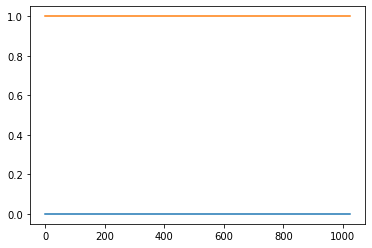

In [6]:
plt.plot(wfs['zero']['data'])
plt.plot(wfs['one']['data'])

And for readout:

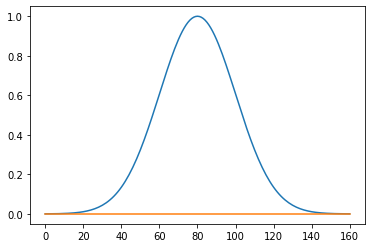

In [7]:
plt.plot(wfs['gauss']['data'])
plt.plot(wfs['empty']['data'])

Finally, we define two acquisitions. A single readout to perform the calibration measurements. Secondly we create a `rabi` readout sequence that contains 50 different bins for saving the results, one for each of the different amplitudes used for the drive tone.

In [8]:
acquisitions = {"single": {"num_bins": 1,
                           "index": 0},
                "rabi": {"num_bins": 50,
                         "index": 1}}

## Calibration experiments

### TOF calibration

As a first step, we calibrate the time of flight (tof) for the QRM module. In order to do so, we play a readout pulse and analyze the obtained signal on the oscilloscope to find the travel time of the pulse through the system.

In [9]:
qrm_prog = f"""
play    1, 0, 4     # start readout pulse
acquire 0, 0, 16384 # start the 'single' acquisition sequence and wait for the length of the scope acquisition window
stop
"""

Upload the program, together with the waveforms and acquisitions to the QRM

In [10]:
wave_and_prog_dict = {"waveforms": wfs, "weights": {}, "acquisitions": acquisitions, "program": qrm_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()
#Upload waveforms and programs.
pulsar_qrm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "sequence.json"))

Perform the calibration experiment

In [11]:
#Arm and start sequencer.
pulsar_qrm.arm_sequencer(0)
pulsar_qrm.start_sequencer()

#Wait for the sequencer to stop with a timeout period of one minute.
pulsar_qrm.get_sequencer_state(0, 1)

#Wait for the acquisition to finish with a timeout period of one minute.
pulsar_qrm.get_acquisition_state(0, 1)
pulsar_qrm.store_scope_acquisition(0, "single")
#Print status of sequencer.
print("Status:")
print(pulsar_qrm.get_sequencer_state(0))

Status:
{'status': 'STOPPED', 'flags': ['FORCED STOP', 'ACQ SCOPE DONE PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ BINNING DONE']}


Analyze the resulting signal on the scope to find the tof

In [12]:
p0 = np.array(pulsar_qrm.get_acquisitions(0)['single']['acquisition']['scope']['path0']['data'])
p1 = np.array(pulsar_qrm.get_acquisitions(0)['single']['acquisition']['scope']['path1']['data'])
tof_measured = np.where(np.abs(p0)>np.max(p0)/2)[0][0]-1/pulsar_qrm.sequencer0_nco_freq()*1e9/8

Plot the signal on the scope, around the rising and falling edge of the acquisition signal, as determined by the tof analysis above:

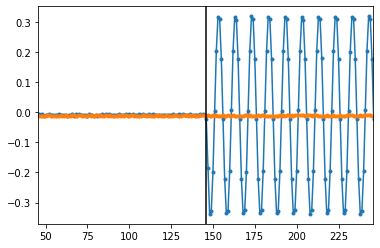

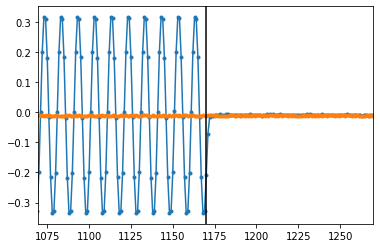

In [13]:
r = pulsar_qrm.get_acquisitions(0)['single']['acquisition']['scope']
plt.plot(r['path0']['data'], '.-')
plt.plot(r['path1']['data'], '.-')
plt.axvline(tof_measured, c='k')
plt.xlim(tof_measured-10/pulsar_qrm.sequencer0_nco_freq()*1e9, tof_measured+10/pulsar_qrm.sequencer0_nco_freq()*1e9)
plt.show()

plt.plot(r['path0']['data'], '.-')
plt.plot(r['path1']['data'], '.-')
plt.axvline(1024+tof_measured, c='k')
plt.xlim(1024+tof_measured-10/pulsar_qrm.sequencer0_nco_freq()*1e9, 1024+tof_measured+10/pulsar_qrm.sequencer0_nco_freq()*1e9)
plt.show()

## Parameters

Set the parameters for the Rabi experiment

In [14]:
# all times must be divisible by 4
reset_time = 200  # reset time for the qubit in microseconds
tof = int(tof_measured/4)*4  # time of flight must be divisible by 4
readout_delay = 164  # time to delay the readout pulse after the start of the rotation pulse

navg = 1000  # number of averages
stepsize = int(65535/100)

## Rabi

Normally, a Rabi experiment would be performed by changing the amplitude in the inner loop, and averaging in the outer loop. To make the resulting experiment visible on an oscilloscope however, in this tutorial we swapped these two loops

In [15]:
#Pulsar QCM sequence program.
qcm_seq_prog = f"""
# Registers used:
# R0 loops over the different awg amplitudes used for the rabi driving pulse
# R2 is used to count the averages needed for a single amplitude
# R3 contains the qubit reset time in microseconds

           wait_sync     4                           # Synchronize the QRM with the QCM
           
           move          0, R0                       # start with awg amplitude 0 
ampl_loop: add           R0, {stepsize}, R0          # increase the pulse amplitude by the stepsize
           move          {navg}, R2                  # reset the number of averages and save in the R2 register
           
           # let the qubit relax to its groundstate
navg_loop: move          {reset_time}, R3            # reset the number of microseconds to wait and save in the R3 register
rst_loop:  wait          1000                        # wait 1 microsecond
           loop          R3,@rst_loop                # repeat the 1 microsecond wait as much as needed to let the qubit relax
           
           set_awg_gain  R0, R0                      # Set the new amplitude used for the drive pulse
           set_mrk       1                           # Set marker 1 high for to enable synchronization with external oscilloscope
           wait_sync     4                           # Synchronize with the qrm to signify a measurement is coming
           play          2,3,16384                   # Play waveforms and wait remaining duration of scope acquisition
           
           set_mrk       0                           # Reset marker 1
           upd_param     4
           
           loop          R2,@navg_loop               # Repeat the experiment to average, until R2 becomes 0
           jlt           R0,{50*stepsize},@ampl_loop # Repeat the experiment for different pulse amplitudes
           stop                                      # Stop.
"""

#Pulsar QRM sequence program.
qrm_seq_prog = f"""
# Registers used:
# R0 counts which bin to acquire into, a new bin for every new amplitude
# R2 is used to count the averages needed for a single amplitude

           wait_sync     4                           # Synchronize the QRM with the QCM.
           move          0, R0                       # the first acquisition uses bin 0
ampl_loop: move          {navg}, R2                  # reset the amount of averages to be taken to the initial value

navg_loop: wait_sync     {readout_delay}             # wait for the QCM to signal a pulse is coming and wait the readout_delay
           play          1,0,{tof}                   # play readout pulse and wait for the tof
           acquire       1,R0,16384                  # Acquire waveforms and wait remaining duration of scope acquisition.
           
           loop          R2, @navg_loop              # Repeat this measurement for every average
           add           R0,1,R0                     # Increment the bin into which we are measuring
           jmp           @ampl_loop                  # repeat
"""

Upload programs and waveforms to QRM and QCM

In [16]:
#Add QCM sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": wfs, "weights": {}, "acquisitions": acquisitions, "program": qcm_seq_prog}
with open("qcm_sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()

#Add QRM sequence program and waveforms to single dictionary and write to JSON file.
wave_and_prog_dict = {"waveforms": wfs, "weights": {}, "acquisitions": acquisitions, "program": qrm_seq_prog}
with open("qrm_sequence.json", 'w', encoding='utf-8') as file:
    json.dump(wave_and_prog_dict, file, indent=4)
    file.close()
    
#Upload waveforms and programs to Pulsar QCM.
pulsar_qcm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "qcm_sequence.json"))

#Upload waveforms and programs to Pulsar QRM.
pulsar_qrm.sequencer0_waveforms_and_program(os.path.join(os.getcwd(), "qrm_sequence.json"))

Arm and start sequencer0 of both the QCM and QRM. The `wait_sync` command together with the SYNQ technology ensures both modules start simultaneously.

In [17]:
#Arm and start sequencer of the Pulsar QCM (only sequencer 0).
pulsar_qcm.arm_sequencer(0)
pulsar_qcm.start_sequencer()

#Print status of sequencer of the Pulsar QCM.
print("QCM status:")
print(pulsar_qcm.get_sequencer_state(0))
print()

#Arm and start sequencer of the Pulsar QRM (only sequencer 0).
pulsar_qrm.arm_sequencer(0)
pulsar_qrm.start_sequencer()

#Print status of sequencer of the Pulsar QRM.
print("QRM status:")
print(pulsar_qrm.get_sequencer_state(0))
print("QCM status:")
print(pulsar_qcm.get_sequencer_state(0, 1))
pulsar_qrm.stop_sequencer(0) # We didn't tell the QRM how many different amplitudes would be measured, so here we tell it to stop.
print("QRM status:")
print(pulsar_qrm.get_sequencer_state(0, 1))


QCM status:
{'status': 'RUNNING', 'flags': []}

QRM status:
{'status': 'RUNNING', 'flags': ['ACQ SCOPE DONE PATH 0', 'ACQ SCOPE OVERWRITTEN PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ SCOPE OVERWRITTEN PATH 1', 'ACQ BINNING DONE']}
QCM status:
{'status': 'STOPPED', 'flags': []}
QRM status:
{'status': 'STOPPED', 'flags': ['FORCED STOP', 'ACQ SCOPE DONE PATH 0', 'ACQ SCOPE OVERWRITTEN PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ SCOPE OVERWRITTEN PATH 1', 'ACQ BINNING DONE']}


## Stop

In [18]:
#Stop sequencers.
pulsar_qcm.stop_sequencer()
pulsar_qrm.stop_sequencer()

#Print status of sequencers.
print("QCM status:")
print(pulsar_qcm.get_sequencer_state(0))
print()

print("QRM status:")
print(pulsar_qrm.get_sequencer_state(0))
print()

#Print an overview of instrument parameters.
print("QCM snapshot:")
pulsar_qcm.print_readable_snapshot(update=True)
print()

print("QRM snapshot:")
pulsar_qrm.print_readable_snapshot(update=True)

#Close the instrument connections.
pulsar_qcm.close()
pulsar_qrm.close()

QCM status:
{'status': 'STOPPED', 'flags': ['FORCED STOP']}

QRM status:
{'status': 'STOPPED', 'flags': ['FORCED STOP', 'ACQ SCOPE DONE PATH 0', 'ACQ SCOPE OVERWRITTEN PATH 0', 'ACQ SCOPE DONE PATH 1', 'ACQ SCOPE OVERWRITTEN PATH 1', 'ACQ BINNING DONE']}

QCM snapshot:
qcm:
	parameter                                  value
--------------------------------------------------------------------------------
IDN                                         :	{'manufacturer': 'Qblox', 'mode...
out0_offset                                 :	0 (V)
out1_offset                                 :	0 (V)
out2_offset                                 :	0 (V)
out3_offset                                 :	0 (V)
reference_source                            :	internal 
sequencer0_channel_map_path0_out0_en        :	True 
sequencer0_channel_map_path0_out2_en        :	True 
sequencer0_channel_map_path1_out1_en        :	True 
sequencer0_channel_map_path1_out3_en        :	True 
sequencer0_cont_mode_en_awg_path0        